# OpenCV DNN Feature Extractor

- not currently working

In [77]:
%reload_ext autoreload
%autoreload 2
import os, sys
from os.path import join
import time
%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob

import numpy as np
import imutils
import cv2 as cv
if not cv.__version__ == '3.4.2':
  print('pip install opencv-python==3.4.2 or greater')

In [78]:
# append notebook imports folder
sys.path.append(str(Path(os.getcwd()).parent))
from utils import imx

In [79]:
# append vframe imports folder
sys.path.append(str(Path(os.getcwd()).parent.parent/'vframe/'))
from vframe.utils import im_utils, file_utils
from vframe.settings import vframe_cfg as cfg

In [80]:
# Asset directories
# change this to a Model Classification Network object
dir_places365 = join(cfg.DIR_MODELS_VFRAME,'caffe/places365')
dir_googlenet = join(dir_places365,'googlenet_places365')
fp_model = join(dir_googlenet, 'googlenet_places365.caffemodel')
fp_prototxt = join(dir_googlenet,'deploy_googlenet_places365.prototxt')
fp_classes = join(dir_places365,'data/categories_places365.txt')

lines = file_utils.load_text(fp_classes)
classes = [line.strip().split(' ')[0][3:] for line in lines]


In [81]:
net = cv.dnn.readNetFromCaffe(fp_prototxt, fp_model)

In [82]:
cfg.DIR_TEST_IMAGES

'/data_store_ssd/apps/syrianarchive/test/images'

In [83]:
# get a test image
im_test_list = glob(join(cfg.DIR_TEST_IMAGES, 'classify', '*'))

In [84]:
fp_im_test = np.random.choice(im_test_list)

In [85]:
im = cv.imread(fp_im_test)

In `cv2.dnn.blobFromImage` check `deploy.prototxt` for dimensions and mean value.

This CNN requires fixed spatial dimensions for our input image(s) so we need to ensure it is resized to 224x224 pixels while performing mean subtraction (104, 117, 123) to normalize the input; after executing this command our "blob" now has the shape: (1, 3, 224, 224)

If the prototxt file throws an error, try using this at top of file:
```
input: "data"
input_shape {
  dim: 1
  dim: 3
  dim: 224
  dim: 224
}
```

In [86]:
dnn_size = (224, 224)
dnn_mean_clr = (104, 117, 123)
dnn_scale = 1

In [87]:
# calc FPS
niters = 10
st = time.time()
for n in range(niters):
    blob = cv.dnn.blobFromImage(im, dnn_scale, dnn_size, dnn_mean_clr)
    net.setInput(blob)
    preds = net.forward()

fps = float(niters) / (time.time()-st)
print("[INFO] FPS {:.5}".format(fps))

[INFO] FPS 61.675


In [88]:
# probabilitiy first) and grab the top-5 predictions
idxs = np.argsort(preds[0])[::-1][:5]

for idx in idxs:
  print('{} ({:.2f}%)'.format(classes[idx], 100*preds[0][idx]))

loading_dock (18.30%)
construction_site (14.67%)
slum (13.28%)
barndoor (6.68%)
hangar/outdoor (4.74%)


[INFO]1. label: loading_dock, probability: 0.18304
[INFO]2. label: construction_site, probability: 0.14671
[INFO]3. label: slum, probability: 0.13279
[INFO]4. label: barndoor, probability: 0.066759
[INFO]5. label: hangar/outdoor, probability: 0.047387


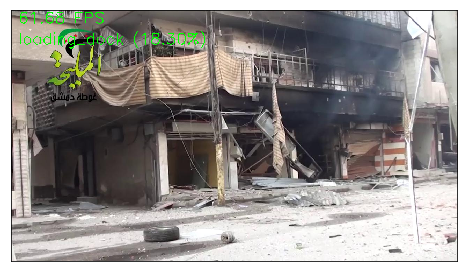

61.68 FPS


<Figure size 432x288 with 0 Axes>

In [89]:
# loop over the top-5 predictions and display them
dst = im.copy()
for (i, idx) in enumerate(idxs):
  # draw the top prediction on the input image
  if i == 0:
      text = "{} ({:.2f}%)".format(classes[idx],
          preds[0][idx] * 100)
      cv.putText(dst, text, (20, 100),  cv.FONT_HERSHEY_SIMPLEX,
          1.5, (0, 255,0), 2)
      cv.putText(dst,'{:.2f} FPS'.format(fps),(20,40),cv.FONT_HERSHEY_SIMPLEX,
          1.5,(0,255,0),2)

  print("[INFO]{}. label: {}, probability: {:.5}".format(i + 1,
      classes[idx], preds[0][idx]))

# # display the output image
imx.pltimg(dst,mode='bgr')
print('{:.2f} FPS'.format(fps))

In [90]:
net.getLayerNames()

['conv1/7x7_s2',
 'conv1/relu_7x7',
 'pool1/3x3_s2',
 'pool1/norm1',
 'conv2/3x3_reduce',
 'conv2/relu_3x3_reduce',
 'conv2/3x3',
 'conv2/relu_3x3',
 'conv2/norm2',
 'pool2/3x3_s2',
 'inception_3a/1x1',
 'inception_3a/relu_1x1',
 'inception_3a/3x3_reduce',
 'inception_3a/relu_3x3_reduce',
 'inception_3a/3x3',
 'inception_3a/relu_3x3',
 'inception_3a/5x5_reduce',
 'inception_3a/relu_5x5_reduce',
 'inception_3a/5x5',
 'inception_3a/relu_5x5',
 'inception_3a/pool',
 'inception_3a/pool_proj',
 'inception_3a/relu_pool_proj',
 'inception_3a/output',
 'inception_3b/1x1',
 'inception_3b/relu_1x1',
 'inception_3b/3x3_reduce',
 'inception_3b/relu_3x3_reduce',
 'inception_3b/3x3',
 'inception_3b/relu_3x3',
 'inception_3b/5x5_reduce',
 'inception_3b/relu_5x5_reduce',
 'inception_3b/5x5',
 'inception_3b/relu_5x5',
 'inception_3b/pool',
 'inception_3b/pool_proj',
 'inception_3b/relu_pool_proj',
 'inception_3b/output',
 'pool3/3x3_s2',
 'inception_4a/1x1',
 'inception_4a/relu_1x1',
 'inception_4a/3x3

In [91]:
nlayers = net.getLayerTypes()
print(nlayers)

['Concat', 'Convolution', 'Dropout', 'InnerProduct', 'LRN', 'Pooling', 'ReLU', 'Softmax', '__NetInputLayer__']


In [92]:
help(net.getUnconnectedOutLayers)

Help on built-in function getUnconnectedOutLayers:

getUnconnectedOutLayers(...) method of cv2.dnn_Net instance
    getUnconnectedOutLayers() -> retval
    .   @brief Returns indexes of layers with unconnected outputs.



In [107]:
ucl = net.getUnconnectedOutLayers()[0][0]
print(ucl)

142


In [108]:
help(net.getLayerId)

Help on built-in function getLayerId:

getLayerId(...) method of cv2.dnn_Net instance
    getLayerId(layer) -> retval
    .   @brief Converts string name of the layer to the integer identifier.
    .   *  @returns id of the layer, or -1 if the layer wasn't found.



In [109]:
net.getLayerId('prob')

142

In [110]:
help(net.getLayer)

Help on built-in function getLayer:

getLayer(...) method of cv2.dnn_Net instance
    getLayer(layerId) -> retval
    .   @brief Returns pointer to layer with specified id or name which the network use.



In [128]:
#a = net.getLayer('inception_5b/output')
a = net.getLayer( 'pool5/7x7_s1')

# a = net.getLayer('loss3/classifier')

In [129]:
help(net.forward)

Help on built-in function forward:

forward(...) method of cv2.dnn_Net instance
    forward([, outputName]) -> retval
    .   @brief Runs forward pass to compute output of layer with name @p outputName.
    .   *  @param outputName name for layer which output is needed to get
    .   *  @return blob for first output of specified layer.
    .   *  @details By default runs forward pass for the whole network.
    
    
    
    forward([, outputBlobs[, outputName]]) -> outputBlobs
    .   @brief Runs forward pass to compute output of layer with name @p outputName.
    .   *  @param outputBlobs contains all output blobs for specified layer.
    .   *  @param outputName name for layer which output is needed to get
    .   *  @details If @p outputName is empty, runs forward pass for the whole network.
    
    
    
    forward(outBlobNames[, outputBlobs]) -> outputBlobs
    .   @brief Runs forward pass to compute outputs of layers listed in @p outBlobNames.
    .   *  @param outputBlobs con

In [138]:
a = net.forward('pool5/7x7_s1')
print(len(a[0]))


1024


In [139]:
print(a[0][:10])

[[[0.5260963 ]]

 [[0.6675271 ]]

 [[0.1432084 ]]

 [[0.06349516]]

 [[0.36837035]]

 [[0.        ]]

 [[0.0284033 ]]

 [[1.3476003 ]]

 [[0.07651842]]

 [[0.30825418]]]


In [134]:
print(a[0].shape)

(1024, 1, 1)


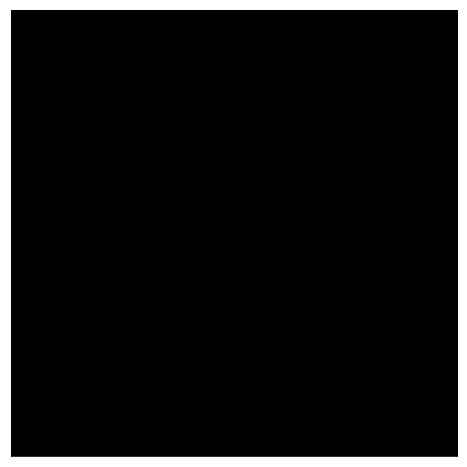

<Figure size 432x288 with 0 Axes>

In [135]:
imx.pltimg(a[0][0], mode='gray')

In [93]:
# b = net.getLayer('loss3/classifier')
#b = net.getLayer('pool5/drop_7x7_s1')
b = net.getLayer('inception_5b/output')

In [66]:
import torchvision.models as models

In [72]:
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/adam/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [06:16<00:00, 1471457.28it/s]


In [71]:
model.named_children

<bound method Module.named_children of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      